# **How house attributes influence the sale price**

## Objectives

**Generate content to satisfy Business requirement 1**:
* Determine how features are correlated to the target, and thus their significance in determining the sale price.

## Inputs

* house prices dataset: outputs/datasets/collection/house_prices.csv

## Outputs


## Conclusions


---

## Change working directory

Working directory changed to its parent folder.

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/heritage_housing_issues/jupyter_notebooks'

In [2]:
os.chdir(os.path.dirname(current_dir))
os.getcwd()

'/workspace/heritage_housing_issues'

---

## Load house prices dataset

In [3]:
import pandas as pd

house_prices_df = pd.read_csv(filepath_or_buffer='outputs/datasets/collection/house_prices.csv')
house_prices_df.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000


---

## House attribute distribution analysis

Produce minimal pandas profiling report for all attributes

In [4]:
import numpy as np
from pandas_profiling import ProfileReport

attribute_profile = ProfileReport(house_prices_df, title='house attribute statistics', minimal=True)
attribute_profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**Comments by variable**:

**1stFlrSF**:
* The distribution has an extended central region with a fairly sharp drop-off, particulary for smaller SF's: mean/median ~ 1100SF, 50% 882-1400SF, 90% 670-1800SF; very large positive kurtosis.
* It has a moderate positive skew, with likely outliers contributing to this. Q3 - median > median - Q2. Max - Q3 >> Q1 - min.
* The very large range is a consequence of the outliers/extreme values.
* Consequence of the extended central region is a moderate amount of dispersion about the mean: 33% CV.
* There is a broad peak close to the median/mean.
* No missing data.

A box plot illustrates the effect of (ignoring) outliers on the 1stFlrSF distribution statistics, and also shows how much of the data is located in an extended central region about the mean.


<AxesSubplot:xlabel='1stFlrSF'>

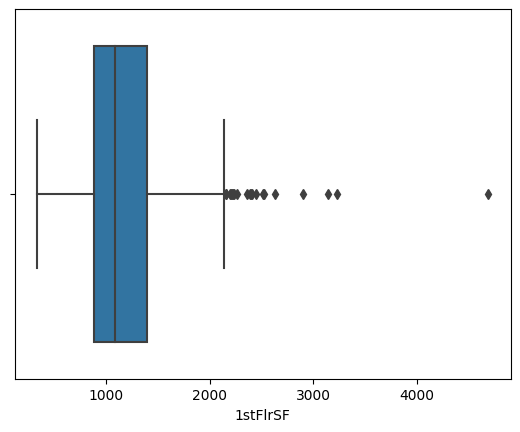

In [5]:
import seaborn as sns

sns.boxplot(x=house_prices_df['1stFlrSF'], whis=1.5)

**2ndFlrSF**:
* 5.9% of the data is missing, a non-negligible proportion.
* Most houses do not have a 2nd floor, >50%.
* distribution stats distorted by these zero data.

Looking at the distribution that excludes properties that have no 2nd floor:

AxesSubplot(0.125,0.11;0.775x0.77)
count     593.000000
mean      807.541315
std       274.580119
min       110.000000
25%       631.000000
50%       780.000000
75%       930.000000
max      2065.000000
Name: 2ndFlrSF, dtype: float64
median: 780.0
5th percentile: 407.0
95-th percentile: 1316.0
skew: 0.7132431513837909
kurtosis: 1.3335573388919792


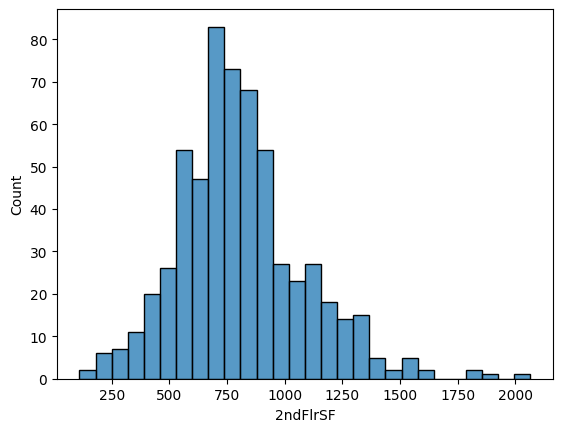

In [6]:
second_flr_series = house_prices_df['2ndFlrSF']
non_zero_second_flr_series = second_flr_series[second_flr_series != 0]
print(sns.histplot(non_zero_second_flr_series))
print(non_zero_second_flr_series.describe())
print('median:', non_zero_second_flr_series.median())
print('5th percentile:', non_zero_second_flr_series.quantile(q=0.05, interpolation='midpoint'))
print('95-th percentile:', non_zero_second_flr_series.quantile(q=0.95, interpolation='midpoint'))
print('skew:', non_zero_second_flr_series.skew())
print('kurtosis:', non_zero_second_flr_series.kurtosis())


Can see that:
* The distribution resembles the distribution for 1stFlrSF, but with a smaller skew and kurtosis.
* Likewise there are possible outliers at higher SF's.


Box plots showing the effect of removing zero data, and the effect of (disregarding) outliers:

<AxesSubplot:>

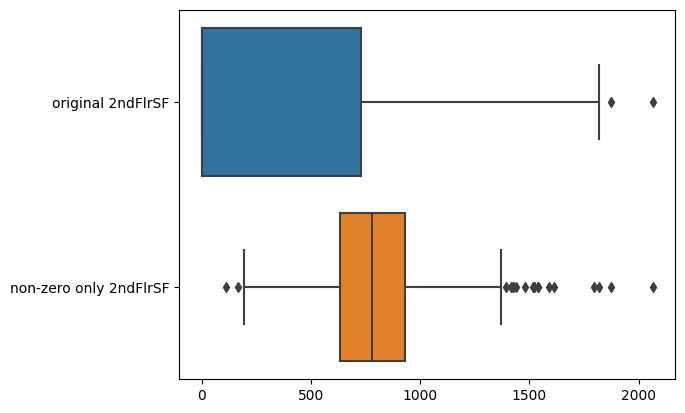

In [7]:
second_flr_df = pd.concat({'original 2ndFlrSF': second_flr_series, 'non-zero only 2ndFlrSF': non_zero_second_flr_series}, axis=1)
sns.boxplot(data=second_flr_df, orient='h')

**BedroomsAbvGr**:
* 6.8% missing data.
* ~90% 2-4 bedrooms above grade.
* ~50% have 3.
* On the whole the BedroomsAbvGr is relatively fixed (3) ±1 bedroom (SD ~ 1).

Box plot:

<AxesSubplot:xlabel='BedroomAbvGr'>

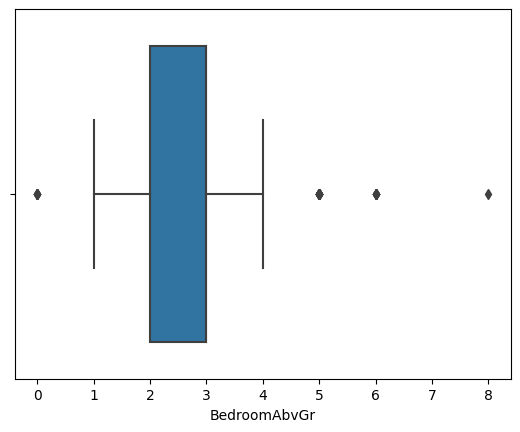

In [8]:
sns.boxplot(x=house_prices_df['BedroomAbvGr'], whis=1.5)

Illustrates that the houses with <1 or >4 bedrooms above grade are likely outliers. It may be useful to group 5+ bedrooms as a category.

Pie chart:

<AxesSubplot:title={'center':'BedroomAbvGr'}>

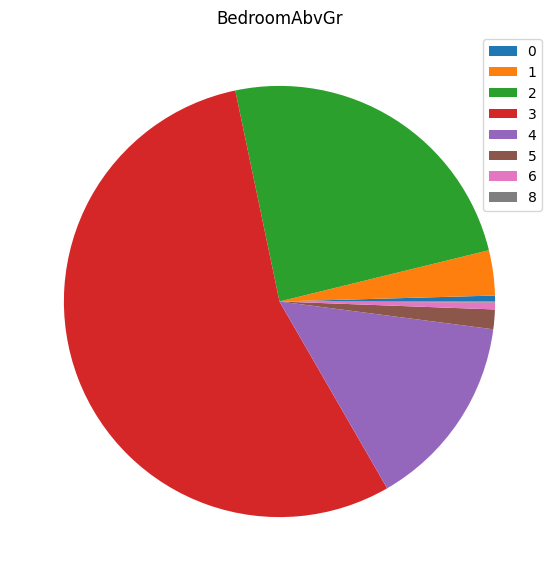

In [58]:

bedrooms_freq_series = house_prices_df['BedroomAbvGr'].value_counts().sort_index()
bedrooms_freq_series.plot(kind='pie', legend=True, labels=[0,1,2,3,4,5,6,8], labeldistance=None, figsize=(7,7), title='BedroomAbvGr', ylabel='')



---

---